通过限制参数值的选择范围来控制模型容量，可以使用均方范数作为柔性限制
权重的更新每次都乘了一个小于1的参数，所以称为权重衰退
权重衰退通过L2正则项使得模型参数不会过大，从而控制模型复杂度
正则项权重是控制模型复杂度的超参数

权重衰减是最广泛使用的正则化的技术之一

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

像以前一样生成一些数据
$$y = 0.05 + \sum_{i=1}^d 0.01x_i + \epsilon where \epsilon \sim N(0, 0.01^2)$$

In [2]:
# 训练数据较小，模型较复杂时更容易发生过拟合
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

初始化模型参数

In [4]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

定义L2范数惩罚

In [24]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2  # L2范数
#     return torch.sum(torch.abs(w))  # L1范数

定义训练代码实现

In [25]:
# 输入的参数是lambda
def train(lambd):
    w, b = init_params()
    # 做一个简单的线性回归，使用平方损失函数
    net, loss = lambda X:d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', 
                            xlim=[5, num_epochs], legend=['train', 'test'])
    # 标准训练
    # 数据迭代
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 加上一个罚
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

忽略正则化直接训练

w的L2范数是： 13.753140449523926


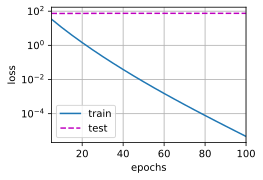

In [26]:
train(lambd=0)

使用权重衰减

w的L2范数是： 0.07181563228368759


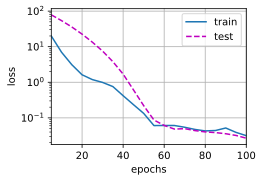

In [23]:
train(lambd=3)

简洁实现

In [16]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # 将权重衰减直接放进trainer里面
    trainer = torch.optim.SGD([{
        "params": net[0].weight, 
        'weight_decay': wd}, {
        "params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, 
                        (d2l.evaluate_loss(net, train_iter, loss), 
                        d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.772529602050781


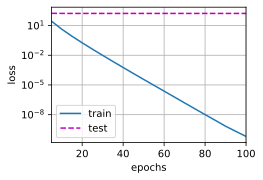

In [17]:
train_concise(0)

w的L2范数： 0.3838551938533783


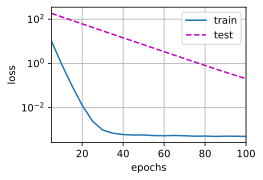

In [19]:
train_concise(3)